In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import re
import os
import cv2

In [3]:
def read_dir_file_names(dirname):
    return [f"{dirname}/{x}" for x in os.listdir(dirname)]

def read_txt(path):
    with open(path, 'r') as f:
        txt = f.read()
        f.close()

    return txt


In [4]:
DE_PATHS = read_dir_file_names("data/DE_TXT")
GA_PATHS = read_dir_file_names("data/GA_TXT")

In [ ]:
SINES_PER_WAVE = 5
PARAMS_PER_SINE = 4
MAX_RUNS = 300
MAX_GENERATIONS = 2400 + 1

In [6]:
import concurrent.futures

def extract_all_sine_params_per_file(paths):
    runs_gen_sine_params = []
    # since we are using thread data unsorted
    paths_after_parsing = []
    pattern = re.compile(r'[-+]?\d*\.\d+|\d+')


    def process_path(path):
        results = []
        txt = read_txt(path)
        txt = [s for s in txt.split("--------------------------------------------------------") if "y=" in s]

        for t_gen in txt:
            extraxted_numbers = pattern.findall(t_gen)

            results.append(
                np.array(extraxted_numbers).astype(np.float64).reshape(SINES_PER_WAVE, PARAMS_PER_SINE)
            )
            
        return results, path

    with concurrent.futures.ThreadPoolExecutor() as executor:
        sines_params = executor.map(process_path, paths)
        
        for (sp, path) in sines_params:
            runs_gen_sine_params.append(sp)
            paths_after_parsing.append(path)

    return runs_gen_sine_params, paths_after_parsing


# runs ->  all params
# runs ->  file paths

In [10]:
de_all_sine_per_run, de_paths_unsorted = extract_all_sine_params_per_file(DE_PATHS)
ga_all_sine_per_run, ga_paths_unsorted = extract_all_sine_params_per_file(GA_PATHS)

de_all_sine_per_run = np.array(de_all_sine_per_run)
ga_all_sine_per_run = np.array(ga_all_sine_per_run)

# runs -> generations -> sines -> params

In [11]:
print('Runs: %d, \nGenerations: %d, \nSines per wave: %d, \nParams per sine: %d' % (MAX_RUNS, MAX_GENERATIONS, SINES_PER_WAVE, PARAMS_PER_SINE))

print('\nNumber of all params:', f"{MAX_RUNS * MAX_GENERATIONS * SINES_PER_WAVE * PARAMS_PER_SINE:,}")

de_all_sine_per_run.shape, ga_all_sine_per_run.shape

Runs: 300, 
Generations: 2401, 
Sines per wave: 5, 
Params per sine: 4

Number of all params: 14,406,000


((300, 2401, 5, 4), (300, 2401, 5, 4))

# Checking of pick 

In [12]:
log_file_content = de_all_sine_per_run[1]
log_file_path = de_paths_unsorted[1]

print(log_file_content.shape, log_file_path)

log_file_content[0][0][0]

(2401, 5, 4) data/DE_TXT/output_10.txt


-0.001120276169775

# Statistics

<h3> Plot Normal Distriution hists </h3>

In [13]:
def plot_distribution_hist(data, title, color, bins_count=6):
    counts, bins, _ = plt.hist(data, bins=bins_count, alpha=0.6, edgecolor='black', weights=np.ones_like(data), color=color, label=title)

    # Compute mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)

    # Generate x values for the bell-shaped curve
    from_point = mean - 4*std_dev
    to_point = mean + 4*std_dev
    x = np.linspace(from_point, to_point, 1000)

    # Compute the PDF (probability density function) of the normal distribution
    pdf = norm.pdf(x, mean, std_dev)

    # Scale the PDF to match the total count of the histogram
    scaling_factor = np.sum(counts) * (bins[1] - bins[0])
    pdf_scaled = pdf * scaling_factor

    # Plot the histogram with counts

    # Plot the bell-shaped curve 
    plt.fill_between(x, 0, pdf_scaled, where=(x >= from_point) & (x <= to_point), color='skyblue', alpha=0.5)

    plt.plot(x, pdf_scaled, 'r-', linewidth=2, color=color)
    plt.axvline(x=0, color='gray', linestyle='--')

    for count, x in zip(counts, bins):
        if count > 0:
            plt.text(x, count, str(int(count)), ha='left', va='bottom')

    # plt.xticks(
    #     np.concatenate(( positive_bins, -positive_bins )), 
    #     rotation=45
    # )

    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.legend()

    # Display the plot
    plt.grid(True)

# Test on normal distributed data

C:\Users\ferra\AppData\Local\Temp\ipykernel_13400\3011219089.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, pdf_scaled, 'r-', linewidth=2, color=color)


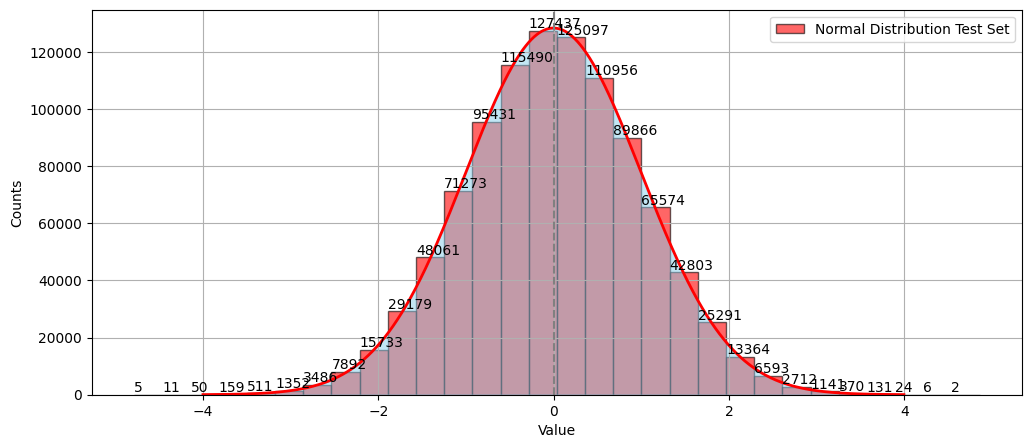

In [14]:
normal_distribution = np.random.normal(0, 1, 1000000)

plt.figure(figsize=(12, 5))
plot_distribution_hist(normal_distribution, "Normal Distribution Test Set", "red", 30)

<h3> Remove Outlayers </h3>

In [15]:
def remove_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return data[z_scores < threshold]

# Using Interquartile Range
def remove_outliers_iqr(data):
    data = np.array(data)

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    cleaned_data = data[(data > lower_bound) & (data < upper_bound)]

    return cleaned_data, outliers

In [16]:
def calc_error(values):
    return np.array(values) - np.mean(values)

def calc_errors_without_outliers(values):
    cleaned_data, outliers = remove_outliers_iqr(values)
    
    return calc_error(cleaned_data), outliers

# Results

In [17]:
PARAM_NAMES = ["Decay", "Amplitude", "Frequency", "Phase"]

False


C:\Users\ferra\AppData\Local\Temp\ipykernel_13400\3011219089.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, pdf_scaled, 'r-', linewidth=2, color=color)


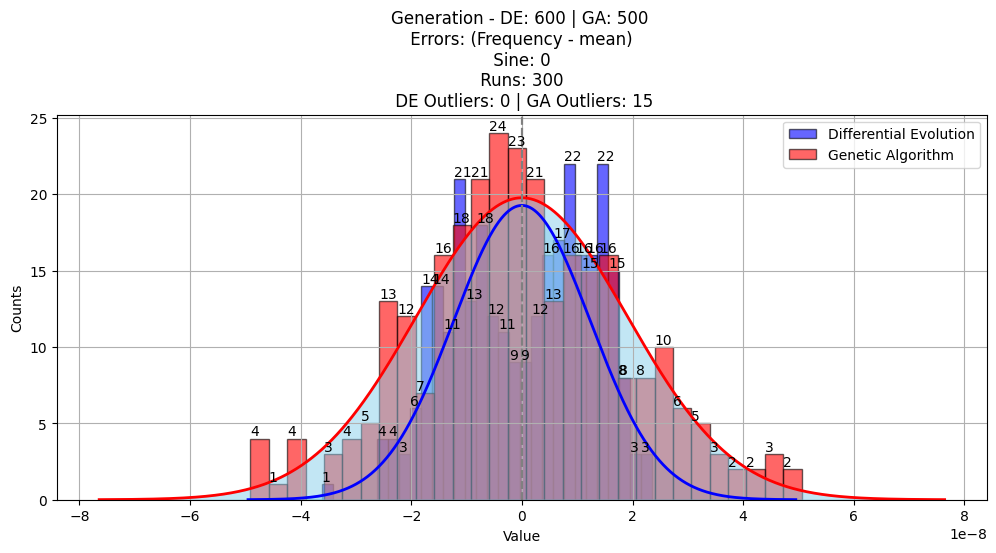

In [310]:
sine_index = 0
param_index = 2

generation_index_de = 600
generation_index_ga = 500


de_data = de_all_sine_per_run[:, generation_index_de, sine_index, param_index]
ga_data = ga_all_sine_per_run[:, generation_index_ga, sine_index, param_index]

de_errors_without_outlayers, de_out = calc_errors_without_outliers(de_data)
ga_errors_without_outlayers, ga_out = calc_errors_without_outliers(ga_data)


# print(np.max(np.abs(de_errors_without_outlayers)) > np.max(np.abs(ga_errors_without_outlayers)))

plt.figure(figsize=(12, 5))
plt.title(f'Generation - DE: {generation_index_de} | GA: {generation_index_ga} \n Errors: ({PARAM_NAMES[param_index]} - mean) \n Sine: {sine_index} \n Runs: 300 \n DE Outliers: {len(de_out)} | GA Outliers: {len(ga_out)}')

plot_distribution_hist(
    de_errors_without_outlayers, 
    "Differential Evolution", 
    'blue', 
    30
)

plot_distribution_hist(
    ga_errors_without_outlayers, 
    "Genetic Algorithm", 
    'red', 
    30
)

# Drawing all 4 sine params for selected sine

In [695]:
def sub_plot_all(sine_index, param_index, generation_index_de, generation_index_ga, bins_count=30):
    de_data = de_all_sine_per_run[:, generation_index_de, sine_index, param_index]
    ga_data = ga_all_sine_per_run[:, generation_index_ga, sine_index, param_index]

    de_errors_without_outlayers, de_out = calc_errors_without_outliers(de_data)
    ga_errors_without_outlayers, ga_out = calc_errors_without_outliers(ga_data)

    de_max_abs_param_err = np.mean(np.abs(de_errors_without_outlayers))
    ga_max_abs_param_err = np.mean(np.abs(ga_errors_without_outlayers))

    # plt.title(f'Errors: ({PARAM_NAMES[param_index]} - mean) \n  DE Outliers: {len(de_out)} | GA Outliers: {len(ga_out)} \n Is DE Better (Is mean error of GA > DE): {de_max_abs_param_err < ga_max_abs_param_err}')

    # plot_distribution_hist(
    #     de_errors_without_outlayers, 
    #     "Differential Evolution", 
    #     'blue', 
    #     bins_count
    # )

    # plot_distribution_hist(
    #     ga_errors_without_outlayers, 
    #     "Genetic Algorithm", 
    #     'red', 
    #     bins_count
    # )

    return de_max_abs_param_err, ga_max_abs_param_err


def plot_all_sine_params(sine_index, generation_de, generation_ga, bins_count=30):
    # plt.figure(figsize=(15, 9))
    RUNS = 300

    de_max_abs_param_errs = np.array([])
    ga_max_abs_param_errs = np.array([])

    for i in range(4):
        # plt.subplot(2, 2, i+1)

        de_max_abs_param_err, ga_max_abs_param_err = sub_plot_all(sine_index, i, generation_de, generation_ga, bins_count)

        de_max_abs_param_errs = np.append(de_max_abs_param_errs, de_max_abs_param_err)
        ga_max_abs_param_errs = np.append(ga_max_abs_param_errs, ga_max_abs_param_err)

        
    # plt.suptitle(f'Runs: {RUNS} | Sine {sine_index} | Generation DE: {generation_de} | Generation GA: {generation_ga}')

    # plt.tight_layout()

    return de_max_abs_param_errs, ga_max_abs_param_errs



In [679]:
de_max_errs, ga_max_errs = plot_all_sine_params(2, generation_de=400, generation_ga=540, bins_count=24)

is_de_better_params = (de_max_errs < ga_max_errs) 

is_all_params_better = np.all(is_de_better_params == True)
is_de_better_params

array([False, False, False, False])

# Average Errors between all params and all runs with outlaers: 
<h2>  mean(["Decay" - mean, "Amplitude" - mean , "Frequency" - mean, "Phase" - mean]) </h2>

In [173]:
# sine_index = 0

# generation_index_de = 800
# generation_index_ga = 1200


# de_sines = de_all_sine_per_run[:, generation_index_de, 0]
# ga_sines = ga_all_sine_per_run[:, generation_index_ga, 0]

# """
# params_means
# [
#     mean Decay, 
#     mean Amplitude,
#     mean Frequency,
#     mean Phase
# ]
# """
# de_params_means = [
#     np.mean(
#         de_all_sine_per_run[:, generation_index_de, sine_index, i]
#     ) for i in range(4)
# ]

# ga_params_means = [
#     np.mean(
#         ga_all_sine_per_run[:, generation_index_ga, sine_index, i]
#     ) for i in range(4)
# ]



# de_errors = de_sines -  de_params_means
# ga_errors = ga_sines -  ga_params_means

# de_errors = [
#     np.mean(errs) for errs in de_errors
# ]
# ga_errors = [
#     np.mean(errs) for errs in ga_errors
# ]

# plt.figure(figsize=(12, 5))

# plt.title(f'Mean Errors of All params for 300 Runs with outlayers\nMean(["Decay" - mean, "Amplitude" - mean , "Frequency" - mean, "Phase" - mean])\nGeneration - DE: {generation_index_de} | GA: {generation_index_ga} ')

# plot_distribution_hist(
#     de_errors, 
#     "Differential Evolution", 
#     'blue', 
#     30
# )

# plot_distribution_hist(
#     ga_errors, 
#     "Genetic Algorithm", 
#     'red', 
#     30
# )

In [ ]:
OUT_FOLDER = 'results/img/GA_DE_ALL_PARAMS'

def make_images_from_plot():
    step = 10
    max_gen = 2400
    sine_index = 0

    for i in range(0, max_gen, step):
        plot_all_sine_params(sine_index, i, i)

        print(i)
        plt.savefig(f'{OUT_FOLDER}/img_{i//step}.png')
        plt.close()

In [ ]:
make_images_from_plot()

In [819]:
# comare ga to de

OUT_FOLDER = 'results/img/GA_DE_ALL_PARAMS_AUTO_INCREMET'

max_gen = 520

step = 10

de_gens_to_compare = np.arange(0, max_gen + 1, step)

def make_images_from_plot():
    sine_index = 0

    de_gen_index = 0
    
    ge_for_de_gens = np.zeros(len(de_gens_to_compare))

    de_gen = de_gens_to_compare[de_gen_index]
    ga_gen = 0

    total = 0

    while de_gen < max_gen and ga_gen < max_gen:
        print(de_gen, ga_gen)
        de_max_errs, ga_max_errs = plot_all_sine_params(sine_index, generation_de=de_gen, generation_ga=ga_gen, bins_count=24)

        is_de_better_params = (de_max_errs < ga_max_errs) 

        is_all_de_params_better = np.all(is_de_better_params == True)

        if is_all_de_params_better:
            ga_gen += step
        else:
            ge_for_de_gens[de_gen_index] = ga_gen
            de_gen_index += 1
            de_gen = de_gens_to_compare[de_gen_index]
        
        # print(f'{de_gen} - {ga_gen} - {total}')

        # plt.savefig(f'{OUT_FOLDER}/img_{total}.png')
        # plt.close()
    
        total += 1

    ge_for_de_gens[de_gen_index] = ga_gen

    return ge_for_de_gens


In [820]:
ge_for_de_gens = make_images_from_plot()

0 0
10 0
20 0
20 10
20 20
30 20
40 20
50 20
50 30
50 40
50 50
50 60
60 60
70 60
70 70
70 80
70 90
80 90
80 100
90 100
90 110
90 120
100 120
100 130
100 140
110 140
110 150
110 160
120 160
120 170
120 180
120 190
130 190
130 200
140 200
140 210
140 220
150 220
150 230
150 240
160 240
160 250
170 250
170 260
180 260
180 270
180 280
190 280
200 280
200 290
210 290
210 300
210 310
220 310
230 310
230 320
230 330
240 330
250 330
250 340
250 350
260 350
270 350
270 360
270 370
280 370
290 370
290 380
300 380
300 390
310 390
310 400
320 400
320 410
330 410
330 420
340 420
350 420
350 430
360 430
370 430
370 440
370 450
380 450
380 460
390 460
390 470
400 470
410 470
410 480
420 480
430 480
430 490
440 490
450 490
460 490
460 500
470 500
480 500
490 500
490 510
500 510
510 510


In [821]:
print(len(ge_for_de_gens), len(de_gens_to_compare))

53 53


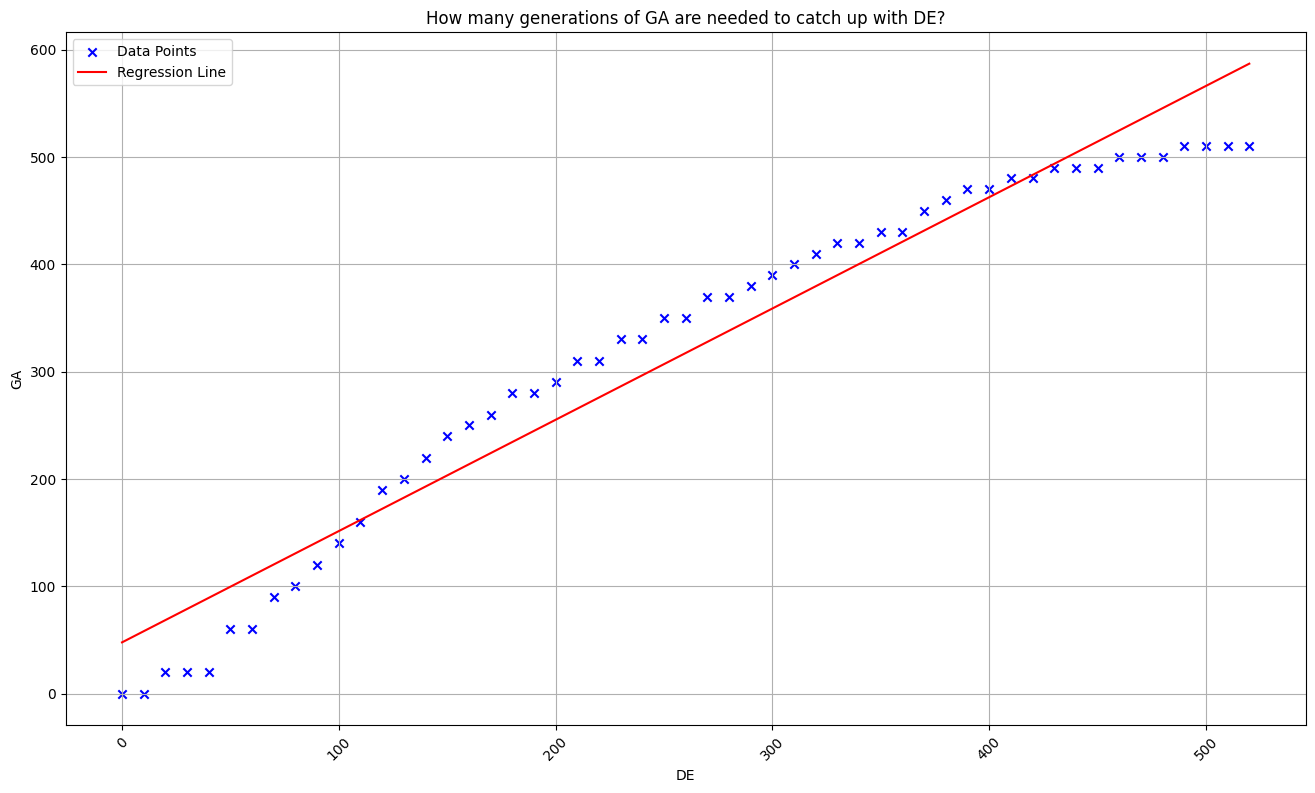

Slope: 1.0367682631833575
R-squared: 0.9741964863111978
Standard deviation: 0.03363447544849761


In [822]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


slope, intercept, r_value, p_value, std_err = stats.linregress(de_gens_to_compare, ge_for_de_gens)
line = slope * de_gens_to_compare + intercept


# Scatter plot
plt.figure(figsize=(16, 9))
plt.scatter(de_gens_to_compare, ge_for_de_gens, label='Data Points', color='blue', marker='x')
plt.plot(de_gens_to_compare, line, color='red', label='Regression Line')

plt.title('How many generations of GA are needed to catch up with DE?')
plt.xlabel('DE')
plt.ylabel('GA')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, max_gen + 1, 100), rotation=45)
plt.show()

# Print coefficients
print(f"Slope: {slope}")
print(f"R-squared: {r_value}")
print(f"Standard deviation: {std_err}")


In [751]:
def create_video_from_images(image_folder, output_video, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort images numerically

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Specify the folder containing the images, the output video path, and frames per second (fps)
output_video = "ga_de_all_auto_inc_params_hist_video3.mp4"
fps = 4  # Frames per second

create_video_from_images(OUT_FOLDER, output_video, fps)

In [257]:

def fmt_sci(val):
        return "{:.2e}".format(val)

def display_bar_plots(ga_data, de_data, title):
    data1 = {
        "sine_name": [1, 2, 3, 4, 5],
        "data": ga_data
    }

    data2 = {
        "data": [1, 2, 3, 4, 5],
        "data": de_data
    }

    sine_names = np.array(data1["sine_name"])

    fig, axs = plt.subplots(1, 5, figsize=(12, 2.5))

    for i, (amp1, amp2) in enumerate(zip(data1["data"], data2["data"])):
        ax = axs[i]
        bars = ax.bar([0, 1], [amp1, amp2], tick_label=['GA', 'DE'], color=['blue', 'orange'])
        ax.set_title(f"Sine №{sine_names[i]}")

        if i == 0:
            ax.set_ylabel(f"{title}")
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['GA', 'DE'])
        max_value = max(amp1, amp2) * 1.1  # 10% higher than the maximum value
        ax.set_ylim(0, max_value)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.4f' % height if height > 1e-4 else fmt_sci(height),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [175]:
print(PARAM_NAMES)

['Decay', 'Amplitude', 'Frequency', 'Phase']


In [206]:
for i in range(4):
    print(i)

0
1
2
3


In [596]:
de_gen = 100
ga_gen = 100


de_params_std = [
    [
        np.std(de_all_sine_per_run[:, de_gen, sine_index, param_index]) for sine_index in range(5)
    ] for param_index in range(4)
]

ga_params_std = [
    [
        np.std(ga_all_sine_per_run[:, ga_gen, sine_index, param_index]) for sine_index in range(5)
    ] for param_index in range(4)
]


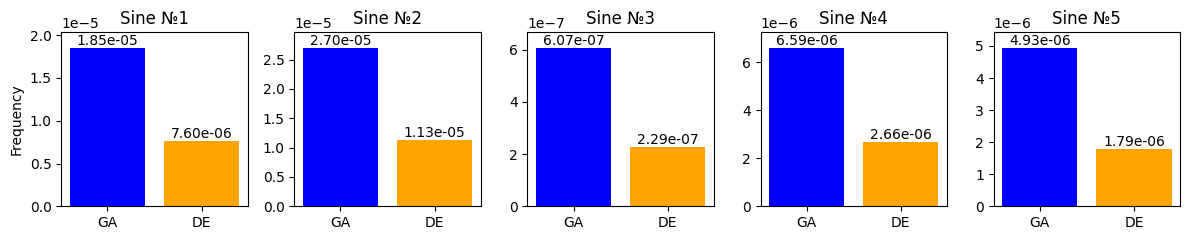

In [597]:
# display_bar_plots(ga_params_std[0], de_params_std[0], "Decay")
# display_bar_plots(ga_params_std[1], de_params_std[1], "Amplitude")
display_bar_plots(ga_params_std[2], de_params_std[2], "Frequency")
# display_bar_plots(ga_params_std[3], de_params_std[3], "Phase")
